In [ ]:
# Устанавливаем зависимости
# ! pip install phik
# ! pip install inflection
# ! pip install catboost

In [ ]:
# Импортируем библиотеки
import warnings
from functools import reduce

import inflection
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix
from tabulate import tabulate

from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    LabelEncoder
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    roc_auc_score,
    auc,
    f1_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

plt.style.use('dark_background')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
cmap = sns.dark_palette("purple", as_cmap=True)

In [ ]:
# Переменная для фиксирования случайности
RANDOM_STATE = 42

In [ ]:
!gdown 1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K  # train.csv
!gdown 1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r  # test.csv
!gdown 199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y  # submission.csv

Downloading...
From: https://drive.google.com/uc?id=1ERwQ5odiK1Zvi1LtjpkzCMUswYsAX8_K
To: /content/train.csv
100% 664k/664k [00:00<00:00, 141MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fGw_-RFwvn_LEdt91Jq-7A-wzG6mmH8r
To: /content/test.csv
100% 218k/218k [00:00<00:00, 86.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=199Mt4OYZNaelT83U-HGDsEYs2YcUGQ6y
To: /content/submission.csv
100% 14.7k/14.7k [00:00<00:00, 34.5MB/s]


# Отток клиентов (DLS)

## Описание проекта

В данном проекте мы будем решать задачу предсказания оттока клиентов  
Это задача бинарной классификации (ушел/не ушел)

### Данные
train.csv - файл с тренировочной выборкой  
test.csv - файл с тестовой выборкой  
submission.csv - файл с примером оформления результата работы

### Метрика
В проекте мы используем для тестирования стандартную для задачи классификации метрику ROC-AUC.  
Она работает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров другого).

## План проекта

1. Загрузим данные и проведем первичный осмотр данных
2. Проведем исследовательский анализ и предобработаем данные
3. Исследуем несколько моделей и выберем финальную модель
5. Протестируем лучшую модель на отложенной выборке и получим финальную метрику

# Обзор данных

Загрузка данных

1. Посмотрим на случайные строчки.
2. Посмотрим, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, заменим их на что-то.

Выведем всю необходимую на этом этапе информацию с помощью функции

Загрузим данные и изучим объекты наблюдений


In [ ]:
ц# Загружаем данные
df = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/submission.csv')

In [ ]:
# Посмотрим все ли хорошо с данными
df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
# Посмотрим на типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Видим, что названия признаков нас не устраивают, приведем к более читаемому виду  
Также видим неверный тип у признака TotalSpent

In [ ]:
# Посмотрим на признак TotalSpent
df.TotalSpent.value_counts().to_frame()

,TotalSpent
,9
20.2,9
19.75,8
20.05,6
19.65,6
...,...
41.85,1
4326.25,1
950.2,1
4264,1


Присутствуют пустые значения, заменим пустые строки на Nan и изменим тип признака

In [ ]:
# Приводим к формату парселтанга
for data in [df, test]:
    data.columns = data.columns.map(lambda x: inflection.underscore(x))

In [ ]:
# Заменим значения равные пустой строке и преобразуем в тип float
for data in [df, test]:
    # Заменим пустые строки на NaN
    data['total_spent'].replace(' ', np.nan, inplace=True)

    # Преобразуем столбец в тип float
    data['total_spent'] = data['total_spent'].astype(float)

Можем приступать к обзору данных

In [ ]:
# Функция для отображения основной информации о выборках
def data_info(data):
    '''
    Explore the data.

    Args:
        data: pd.DataFrame - the main dataset for analysis

    Returns:
        Random 5 rows of the dataframe,
        General information about the data size and features,
        Basic statistics of the data,
        Distribution of values in the features,
        Proportions of missing values in the data

    '''
    # Получаем словарь глобальных переменных
    global_vars = globals()

    # Найдем имя переменной на основе объекта датасета
    dataset_name = next(
        name for name, value in global_vars.items() if value is data)

    # Вывод имени датасета
    print(f'\033[1m\033[4mDataset: {dataset_name.upper()}\033[0m\n')

    # Случайные 5 строк датафрейма
    print("\033[1mRandom 5 rows of data:\033[0m\n")
    display(data.sample(5))
    print(f'Data size: {data.shape}')

    # Основная информация датафрейма
    print("\n\033[1mGeneral information about the data:\033[0m\n")
    print(pd.DataFrame(data.dtypes))

    # Основные статистики
    print("\n\033[1mBasic statistics of the data:\033[0m\n")
    display(data.describe(include='all'))

    # Распределение частоты значений по признакам
    print("\n\033[1mDistribution of values in the features:\033[0m\n")
    for column in data.columns:
        print(f"\n\033[1mFeature: {column}\033[0m")
        print(tabulate(
            data[column].value_counts(ascending=False, dropna=False).head().reset_index(),
            headers='keys', tablefmt='fancy_grid', showindex=False)
    )

    # Пропущенные значения
    print("\n\033[1mProportions of missing values:\033[0m\n")
    display(data.isna().mean().to_frame())


In [ ]:
# Тренировочная выборка
data_info(df)

Dataset: DF

Random 5 rows of data:



,client_period,monthly_spending,total_spent,sex,is_senior_citizen,has_partner,has_child,has_phone_service,has_multiple_phone_numbers,has_internet_service,has_online_security_service,has_online_backup,has_device_protection,has_tech_support_access,has_online_tv,has_movie_subscription,has_contract_phone,is_billing_paperless,payment_method,churn
4999,22,76.00,1783.60,Female,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,One year,Yes,Credit card (automatic),0
4519,3,89.85,248.40,Male,0,Yes,Yes,Yes,No,Fiber optic,Yes,Yes,No,No,Yes,No,Month-to-month,No,Electronic check,0
823,32,85.30,2661.10,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Electronic check,1
255,13,19.45,232.10,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),0
1308,1,39.65,39.65,Male,1,No,No,No,No phone service,DSL,No,No,Yes,No,No,Yes,Month-to-month,Yes,Electronic check,1


Data size: (5282, 20)

General information about the data:

                                   0
client_period                  int64
monthly_spending             float64
total_spent                  float64
sex                           object
is_senior_citizen              int64
has_partner                   object
has_child                     object
has_phone_service             object
has_multiple_phone_numbers    object
has_internet_service          object
has_online_security_service   object
has_online_backup             object
has_device_protection         object
has_tech_support_access       object
has_online_tv                 object
has_movie_subscription        object
has_contract_phone            object
is_billing_paperless          object
payment_method                object
churn                          int64

Basic statistics of the data:



,client_period,monthly_spending,total_spent,sex,is_senior_citizen,has_partner,has_child,has_phone_service,has_multiple_phone_numbers,has_internet_service,has_online_security_service,has_online_backup,has_device_protection,has_tech_support_access,has_online_tv,has_movie_subscription,has_contract_phone,is_billing_paperless,payment_method,churn
count,5282.000000,5282.000000,5273.000000,5282,5282.000000,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282,5282.000000
unique,NaN,NaN,NaN,2,NaN,2,2,2,3,3,3,3,3,3,3,3,3,2,4,NaN
top,NaN,NaN,NaN,Male,NaN,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN
freq,NaN,NaN,NaN,2655,NaN,2705,3676,4761,2511,2341,2612,2332,2317,2604,2099,2081,2920,3148,1786,NaN
mean,32.397009,64.924754,2291.390461,NaN,0.159409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.262022
std,24.550326,30.176464,2269.014233,NaN,0.366092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.439776
min,0.000000,18.250000,18.800000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,9.000000,35.462500,401.100000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,29.000000,70.400000,1410.250000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,55.000000,90.050000,3807.350000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000



Distribution of values in the features:


Feature: client_period
╒═════════╤═════════════════╕
│   index │   client_period │
╞═════════╪═════════════════╡
│       1 │             457 │
├─────────┼─────────────────┤
│      72 │             284 │
├─────────┼─────────────────┤
│       2 │             165 │
├─────────┼─────────────────┤
│       3 │             162 │
├─────────┼─────────────────┤
│       4 │             136 │
╘═════════╧═════════════════╛

Feature: monthly_spending
╒═════════╤════════════════════╕
│   index │   monthly_spending │
╞═════════╪════════════════════╡
│   20.05 │                 46 │
├─────────┼────────────────────┤
│   19.65 │                 35 │
├─────────┼────────────────────┤
│   19.95 │                 34 │
├─────────┼────────────────────┤
│   20    │                 33 │
├─────────┼────────────────────┤
│   19.7  │                 32 │
╘═════════╧════════════════════╛

Feature: total_spent
╒═════════╤═══════════════╕
│   index │   total_spent │
╞═════════

,0
client_period,0.000000
monthly_spending,0.000000
total_spent,0.001704
sex,0.000000
is_senior_citizen,0.000000
has_partner,0.000000
has_child,0.000000
has_phone_service,0.000000
has_multiple_phone_numbers,0.000000
has_internet_service,0.000000


In [ ]:
# Тестовая выборка
data_info(test)

Dataset: TEST

Random 5 rows of data:



,client_period,monthly_spending,total_spent,sex,is_senior_citizen,has_partner,has_child,has_phone_service,has_multiple_phone_numbers,has_internet_service,has_online_security_service,has_online_backup,has_device_protection,has_tech_support_access,has_online_tv,has_movie_subscription,has_contract_phone,is_billing_paperless,payment_method
1654,68,19.50,1193.55,Male,1,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic)
1262,1,19.20,19.20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check
1720,68,19.95,1303.25,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic)
1573,66,62.50,4136.40,Female,0,No,No,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic)
217,1,69.95,69.95,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check


Data size: (1761, 19)

General information about the data:

                                   0
client_period                  int64
monthly_spending             float64
total_spent                  float64
sex                           object
is_senior_citizen              int64
has_partner                   object
has_child                     object
has_phone_service             object
has_multiple_phone_numbers    object
has_internet_service          object
has_online_security_service   object
has_online_backup             object
has_device_protection         object
has_tech_support_access       object
has_online_tv                 object
has_movie_subscription        object
has_contract_phone            object
is_billing_paperless          object
payment_method                object

Basic statistics of the data:



,client_period,monthly_spending,total_spent,sex,is_senior_citizen,has_partner,has_child,has_phone_service,has_multiple_phone_numbers,has_internet_service,has_online_security_service,has_online_backup,has_device_protection,has_tech_support_access,has_online_tv,has_movie_subscription,has_contract_phone,is_billing_paperless,payment_method
count,1761.000000,1761.000000,1759.000000,1761,1761.000000,1761,1761,1761,1761,1761,1761,1761,1761,1761,1761,1761,1761,1761,1761
unique,NaN,NaN,NaN,2,NaN,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,NaN,NaN,NaN,Male,NaN,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,NaN,NaN,NaN,900,NaN,936,1257,1600,879,755,886,756,778,869,711,704,955,1023,579
mean,32.293583,64.272601,2259.048778,NaN,0.170358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,24.593736,29.832517,2260.504905,NaN,0.376054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,18.550000,18.850000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,9.000000,35.650000,409.525000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,29.000000,70.050000,1356.700000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,56.000000,89.400000,3763.225000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Distribution of values in the features:


Feature: client_period
╒═════════╤═════════════════╕
│   index │   client_period │
╞═════════╪═════════════════╡
│       1 │             156 │
├─────────┼─────────────────┤
│      72 │              78 │
├─────────┼─────────────────┤
│       2 │              73 │
├─────────┼─────────────────┤
│       4 │              40 │
├─────────┼─────────────────┤
│      71 │              39 │
╘═════════╧═════════════════╛

Feature: monthly_spending
╒═════════╤════════════════════╕
│   index │   monthly_spending │
╞═════════╪════════════════════╡
│   19.85 │                 15 │
├─────────┼────────────────────┤
│   20.05 │                 15 │
├─────────┼────────────────────┤
│   20.25 │                 14 │
├─────────┼────────────────────┤
│   20.15 │                 13 │
├─────────┼────────────────────┤
│   19.9  │                 13 │
╘═════════╧════════════════════╛

Feature: total_spent
╒═════════╤═══════════════╕
│   index │   total_spent │
╞═════════

,0
client_period,0.000000
monthly_spending,0.000000
total_spent,0.001136
sex,0.000000
is_senior_citizen,0.000000
has_partner,0.000000
has_child,0.000000
has_phone_service,0.000000
has_multiple_phone_numbers,0.000000
has_internet_service,0.000000


In [ ]:
# Выборка с примером результата
submission.head()

,Id,Churn
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [ ]:
# Посмотрим на некорректное значение признака total_spent
df[df['total_spent'].isna()]

,client_period,monthly_spending,total_spent,sex,is_senior_citizen,has_partner,has_child,has_phone_service,has_multiple_phone_numbers,has_internet_service,has_online_security_service,has_online_backup,has_device_protection,has_tech_support_access,has_online_tv,has_movie_subscription,has_contract_phone,is_billing_paperless,payment_method,churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


Как можем заметить наблюдения в которых, общее число платежей равно пустой строке, являются новыми пользователями, проверим гипотезу о том, что можем заполнить значения для этих наблюдений просто столбцом monthly_spending

In [ ]:
# Посмотрим на остальные данные
df.head()

,client_period,monthly_spending,total_spent,sex,is_senior_citizen,has_partner,has_child,has_phone_service,has_multiple_phone_numbers,has_internet_service,has_online_security_service,has_online_backup,has_device_protection,has_tech_support_access,has_online_tv,has_movie_subscription,has_contract_phone,is_billing_paperless,payment_method,churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [ ]:
# Проверяем гипотезу
result_df = (
    df[['client_period', 'monthly_spending']].assign(
        result=df['client_period'] * df['monthly_spending']
    )
)
result_df['total_spent'] = df['total_spent']

# Выведем результат
result_df.sample(15)

,client_period,monthly_spending,result,total_spent
342,1,70.60,70.60,70.60
739,58,100.35,5820.30,5681.10
2569,1,69.10,69.10,69.10
521,37,19.80,732.60,695.05
3563,28,105.80,2962.40,2998.00
5191,50,20.55,1027.50,1070.25
156,4,23.90,95.60,97.50
151,2,61.20,122.40,125.95
1449,48,26.30,1262.40,1245.05
2511,3,69.55,208.65,200.20


Как мы видим некоторые общие затраты совпадают с расчетом произведения общих дней пользования услугами и ежемесячной оплатой, но в большинстве случаев присутсвует незначительное отклонение, так как у нас не так много наблюдений с пропущенными значениями в следствии того, что для этих наблюдений еще нет подгруженных данных, у нас есть три варианта заполнения пропусков:
+ Заполнить значением из столбца monthly_spending, так как пользование услугами уже происходит (присутствуют значения в столбце monthly_spending, можем сказать что тарифы распределены)
+ Заполнить значения нулями, так как возможно это пользователи, которые пришли по промо акции и имеют бесплатный период
+ Удалить эти наблюдения, так как их очень мало


Выберем заполнение пропущенных значений значениями из столбца monthly_spending

In [ ]:
# Заполняем пропущенные значения
df['total_spent'] = df['total_spent'].fillna(df['monthly_spending'])

In [ ]:
# Посмотрим на дубликаты
df[df.duplicated(keep=False)]

,client_period,monthly_spending,total_spent,sex,is_senior_citizen,has_partner,has_child,has_phone_service,has_multiple_phone_numbers,has_internet_service,has_online_security_service,has_online_backup,has_device_protection,has_tech_support_access,has_online_tv,has_movie_subscription,has_contract_phone,is_billing_paperless,payment_method,churn
7,1,45.70,45.70,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
170,1,69.90,69.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
329,1,69.35,69.35,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
409,1,69.60,69.60,Female,1,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
594,1,20.05,20.05,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
838,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1068,1,70.15,70.15,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1
1217,1,20.20,20.20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,1
1236,1,45.30,45.30,Male,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,1
1384,1,69.90,69.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1


### Промежуточный вывод:

+ Размер тренировочной выборки 5282 объекта на 20 признаков, будем работать с ней
+ Размер тестовой выборки 1761 объект на 19 признаков, отсутствует целевой признак, так как эта выборка необходима для тестирования финальной модели на Kaggle, на этой выборке будем получать финальную оценку, после нахождения лучшей модели предобработаем эту выборку по аналогии с тренировочными данными, пока забываем про нее до финала
+ В тренировочной выборке 3 признака непрерывных и 17 категориальных (8 из которых бинарные) один из них наш целевой признак,
+ Признаки имели формат PascalCase, перевели в привычный парселтанг (snake_case),
+ Признак total_spent имел некорректный тип данных object - перевели в float, также имелись пустые значения в количестве 9 штук (пустая строка), заменили на NaN провели анализ гипотезы и приняли решение заполнить пропущенные значения значениями из признака monthly_spending
+ Тип признака is_senior_citizen числовой, уже преобразованный, оставим его для кодировщиков
+ Дубликаты в данной задаче не имеют значения, так как возможны полные копии наблюдений, но могут относится к разным пользователям, в данном случае присутствуют полные дубликаты наблюдений с временем пользования сервисами равным одному месяцу
+ Пропусков нет

## Анализ данных

1) Для численных призанков построим гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитаем количество каждого значения для каждого признака. Для каждой колонки сделаем *data.value_counts()* и построим диаграммы.

2) Посмотрим на распределение целевой переменной и скажем, являются ли классы несбалансированными.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

Для начала изучим целевой признак

In [ ]:
# Распределение целевого признака
df['churn'].value_counts(normalize=True).to_frame()

,churn
0,0.737978
1,0.262022


Целевой признак несбалансирован в соотношении 74% к 26%, это необходимо учесть во время исследования  моделей, мы не будем использовать дополнительные методы по типу ап/даун семплинга, ограничимся встроенными методами эстиматоров

Сокращу часть с анализом данных до MVP,  так как могу закопаться в EDA на неделю, да и читать это вам надоест😉

Разделим признаки на категориальные и численные, для удобства построения графиков

In [ ]:
# Выведем строку для удобства
df.head(1)

,client_period,monthly_spending,total_spent,sex,is_senior_citizen,has_partner,has_child,has_phone_service,has_multiple_phone_numbers,has_internet_service,has_online_security_service,has_online_backup,has_device_protection,has_tech_support_access,has_online_tv,has_movie_subscription,has_contract_phone,is_billing_paperless,payment_method,churn
0,55,19.5,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0


In [ ]:
# Переменные с категориальными и численными признаками
cat = df.iloc[:, 3:]
num = df.iloc[:, :3].columns

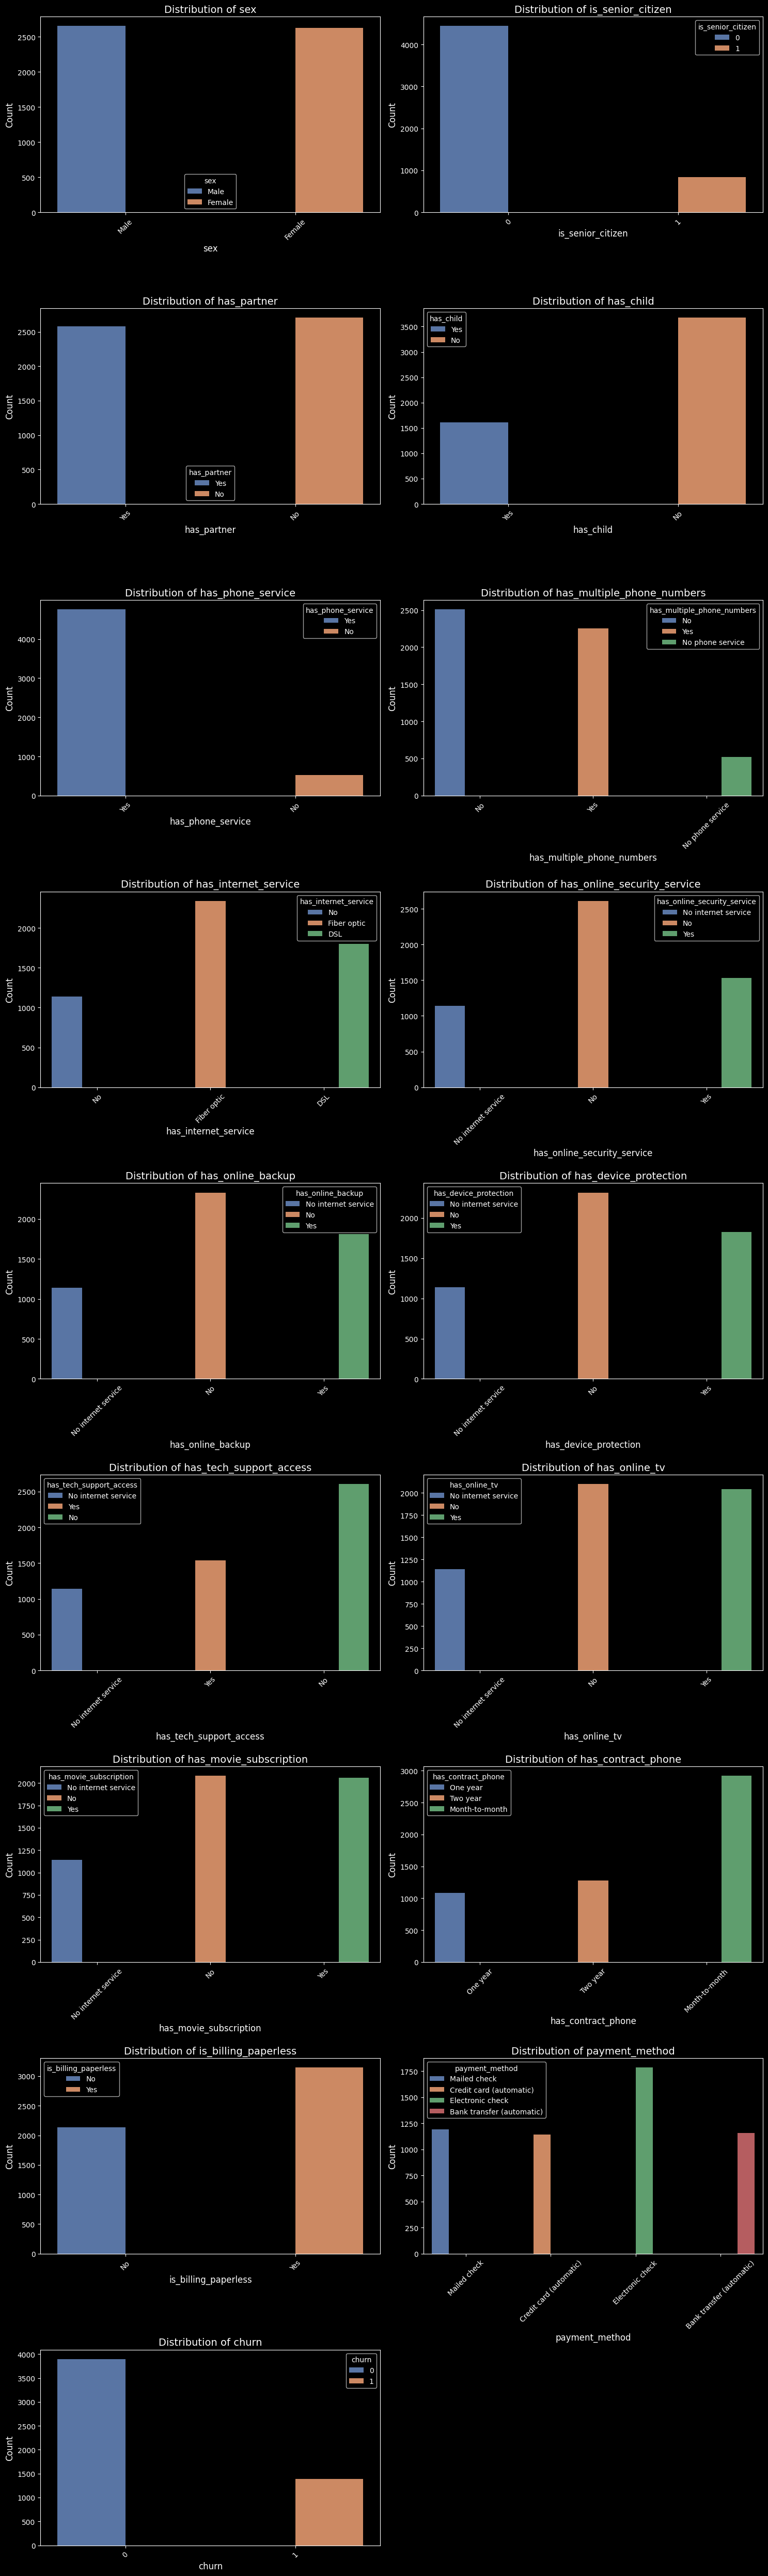

In [ ]:
# Создаем сетку графиков с 9 строками и 2 столбцами
fig, axes = plt.subplots(9, 2, figsize=(15, 50))

# Преобразуем 2D массив осей в 1D массив
axes = axes.flatten()

# Используем цикл для построения гистограмм на каждой подсетке
for i, feature in enumerate(cat):
    # Проверка, чтобы не выйти за границы доступных подсеток
    if i < len(axes):
        sns.countplot(x=feature, hue=feature, data=df, palette='deep', ax=axes[i])

        # Настройка осей и заголовков
        axes[i].set_xlabel(feature, fontsize=12)
        axes[i].set_ylabel('Count', fontsize=12)
        axes[i].set_title(f'Distribution of {feature}', fontsize=14)
        axes[i].tick_params(axis='x', rotation=45)

# Удаляем последний (пустой) график
fig.delaxes(axes[-1])

# Расположение графиков
plt.tight_layout()

# Отображение графиков
plt.show()

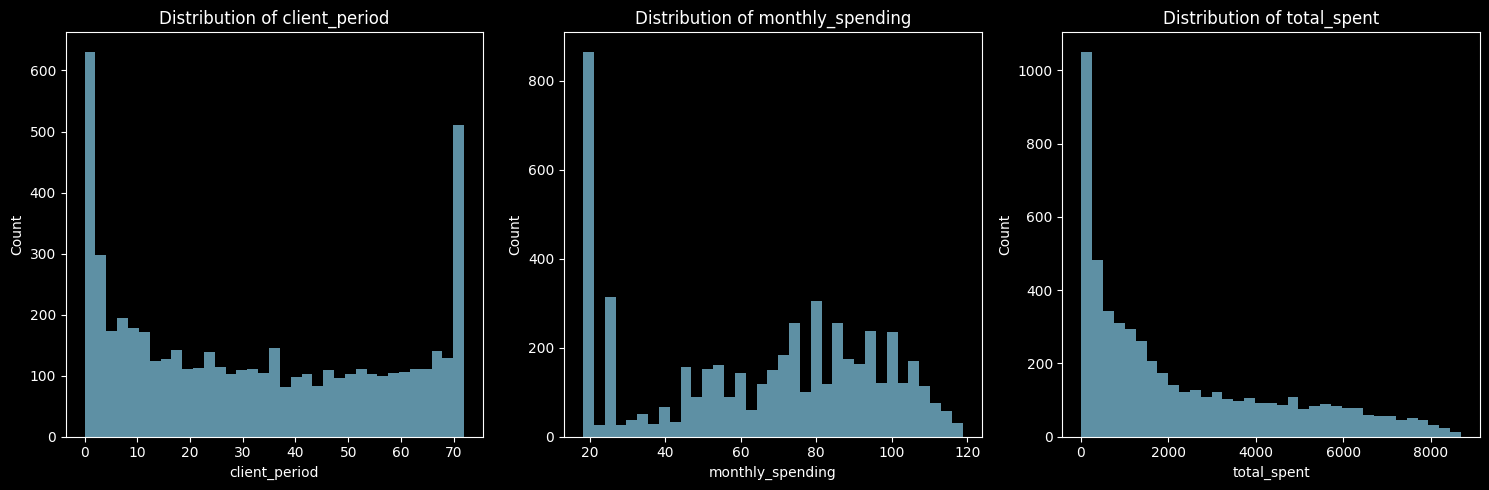

In [ ]:
# Создаем сетку графиков с 1 строкой и 3 столбцами (для 3 численных признаков)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Построение гистограмм для каждого численного признака
for i, feature in enumerate(num):
    axes[i].hist(df[feature], bins=35, color='skyblue', alpha=0.7)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')

# Регулировка расположения и отображение графиков
plt.tight_layout()
plt.show()

Посмотрим на зависимости между признаками и целевым признаком, а также наличие мультиколлинеарности

In [ ]:
# Строим матрицу корреляции с помощью Фи-ка
phik_corr = df.phik_matrix(interval_cols=num)

In [ ]:
# Корреляция с целевым признаком
(
    phik_corr['churn'].sort_values(ascending=False)
                      .to_frame()
                      .style.background_gradient(cmap=cmap))

,churn
churn,1.000000
client_period,0.469423
payment_method,0.442566
monthly_spending,0.360202
is_billing_paperless,0.298737
total_spent,0.278635
has_child,0.252610
has_contract_phone,0.250575
is_senior_citizen,0.242130
has_partner,0.229302


In [ ]:
# Матрица корреляции
phik_corr.style.background_gradient(cmap=cmap)

,client_period,monthly_spending,total_spent,sex,is_senior_citizen,has_partner,has_child,has_phone_service,has_multiple_phone_numbers,has_internet_service,has_online_security_service,has_online_backup,has_device_protection,has_tech_support_access,has_online_tv,has_movie_subscription,has_contract_phone,is_billing_paperless,payment_method,churn
client_period,1.000000,0.418788,0.841446,0.000000,0.056182,0.478140,0.193476,0.000000,0.375206,0.018315,0.377541,0.401831,0.406591,0.364214,0.317887,0.340639,0.668796,0.000000,0.365148,0.469423
monthly_spending,0.418788,1.000000,0.760248,0.014701,0.295128,0.198542,0.201192,0.825839,0.704894,0.918226,0.812322,0.818052,0.826429,0.815616,0.866389,0.864086,0.393018,0.458322,0.391187,0.360202
total_spent,0.841446,0.760248,1.000000,0.000000,0.143156,0.413656,0.106521,0.198566,0.492357,0.503677,0.529983,0.567912,0.575333,0.534023,0.565349,0.571584,0.504668,0.199826,0.343393,0.278635
sex,0.000000,0.014701,0.000000,1.000000,0.000000,0.000000,0.005473,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010556,0.000000,0.000000
is_senior_citizen,0.056182,0.295128,0.143156,0.000000,1.000000,0.013571,0.332861,0.000000,0.082925,0.156235,0.124919,0.108653,0.109508,0.131740,0.110391,0.113244,0.088111,0.234705,0.290924,0.242130
has_partner,0.478140,0.198542,0.413656,0.000000,0.013571,1.000000,0.639777,0.000000,0.083427,0.000000,0.092202,0.087910,0.100845,0.078076,0.078075,0.078716,0.178090,0.000000,0.240076,0.229302
has_child,0.193476,0.201192,0.106521,0.005473,0.332861,0.639777,1.000000,0.000000,0.014488,0.115435,0.124478,0.103165,0.099658,0.114890,0.094849,0.093090,0.144618,0.155535,0.218179,0.252610
has_phone_service,0.000000,0.825839,0.198566,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.283895,0.107396,0.105146,0.104254,0.108308,0.109085,0.108897,0.000000,0.024323,0.000000,0.000000
has_multiple_phone_numbers,0.375206,0.704894,0.492357,0.000000,0.082925,0.083427,0.014488,1.000000,1.000000,0.740386,0.538067,0.560205,0.561795,0.536613,0.581686,0.582699,0.253245,0.096608,0.173641,0.020756
has_internet_service,0.018315,0.918226,0.503677,0.000000,0.156235,0.000000,0.115435,0.283895,0.740386,1.000000,0.949750,0.942820,0.942799,0.949417,0.947313,0.946368,0.502910,0.226499,0.313857,0.192010


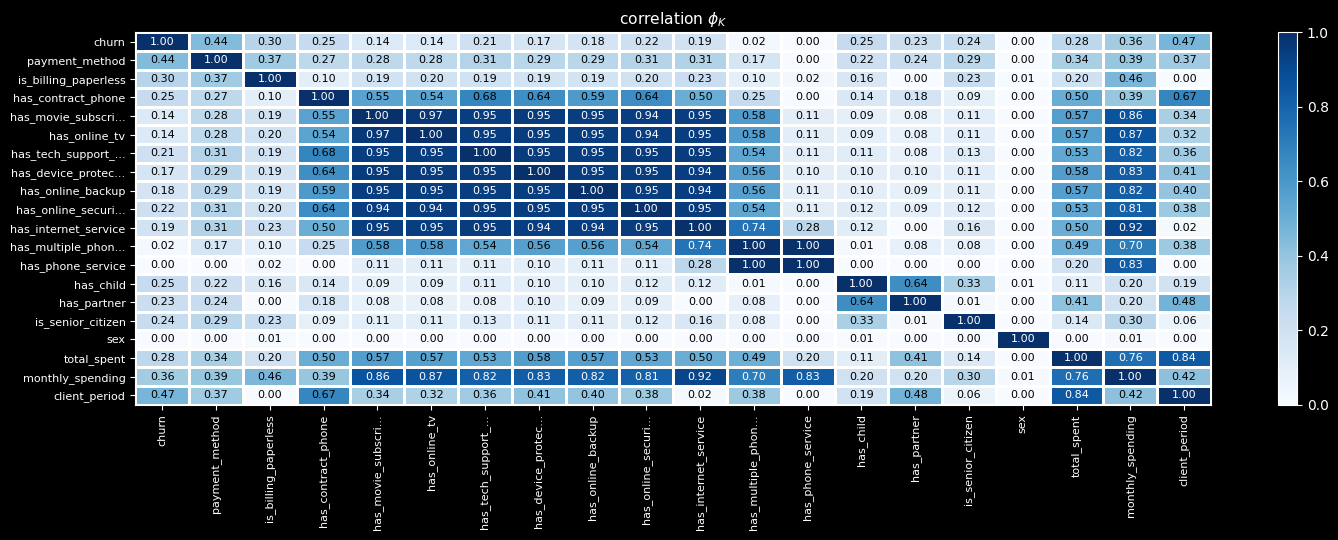

In [ ]:
# Нарисуем график полной корреляции для нашего датасета
plot_correlation_matrix(phik_corr.values, x_labels=phik_corr.columns, y_labels=phik_corr.index,
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=.8,
                        figsize=(15,5.5))
plt.tight_layout()

### Вывод по анализу данных:

+ Категориальные признаки:
    + Целевой признак несбалансирован, соотношение 76 к 24%, необходимо это учесть при исследовании моделей
    + Способ оплаты доминирует electronic_check, остальные способы примерно равны между собой
    + Большая часть пользователей предпочитает не получать бумажные чеки
    + У большинства пользователей подключена помесячная подписка на телефон, в два раза меньше пользователей пользуются двухгодичной подпиской, немного меньше ежегодной
    + Примерно одинаковое количество людей кто пользуется подпиской на фильмы и тех у кого нет подписки, в половину меньше у кого нет интернет сервиса
    + У большего числа пользователей нет онлайн тв, чуть меньше пользователей имеют телевидение, в два раза меньше пользователей у которых нет интернет сервиса
    + Большее число пользователей не имеют сервиса технической поддержки
    + Также дела обстоят с сервисом защиты устройств, онлайн резеврной копией, онлайн службой безопасности
    + Большинство пользователей использую оптоволоконное подключение, чуть меньше пользователей используют цифровое подключение
    + Возможностю подключения телефонного номера к нескольким линиям одновременно не пользуется большинство пользователей, чуть меньше подключили такую услугу, достаточно мало человек не используют телефонные сервисы
    + Распределение в выборке мужчин и женщин примерно одинаково, такая же ситуация с наличием партнера, большинство не имеет детей и не пенсионного возраста
    
    
+ Численные признаки:
    + client_period:

        Гистограмма для client_period показывает, что большинство клиентов пользовались услугами компании относительно недавно, с низким значением client_period.  
        Это видно из высокого столбца близкого к 0 на гистограмме.   
        Со временем количество клиентов убывает, что видно из уменьшения высоты столбцов при увеличении client_period.
        Однако есть также большая доля клиентов, которые пользуются услугами длительное время и составляют второй пик в конце.
        Распределение признака напоминает экспоненциальное распределение с двумя пиками.
        
    + monthly_spending:

        Гистограмма для monthly_spending показывает, что есть пик при низких ежемесячных трат и более равномерное низкое распределение далее, меньше всего пользователей с ежемесечной платой в диапазоне от 30 до 45.   
        Это указывает на наличие основной группы клиентов: с низкими ежемесячными расходами.   
        Распределение признака является одномодальным, с одним характерным значением.  
        
    + total_spent:

        Распределение признака total_spent является также одномодальным, с одним характерным значением, и показывает, что большинство клиентов имеют низкие общие траты.
        Присутствует жирный хвост до значений больше 8_000  
        Значения плавно уходят в жирный хвост, с увеличением общих трат и уменьшается количество пользователей.  
        Распределение признака является одномодальным.
        
+ Матрица корреляции:

    + Сильная корреляция между некоторыми признаками:   
        Все признаки интернет сервисов очень сильно положительно коррелируют друг с другом, что приведет к мультиколлинеарности  
        Это усложняет интерпретацию важности каждого из этих признаков и может привести к нестабильным оценкам модели. Например, has_online_security_service, has_online_backup, has_device_protection, и has_tech_support_access сильно коррелируют друг с другом. Рассмотрим удаление некоторых из них.

    + Слабая корреляция с целевой переменной:  
        Некоторые признаки имеют низкую корреляцию с целевой переменной churn. Например, has_multiple_phone_numbers, sex, has_phone_service имеют практически нулевую корреляцию с churn.   
        Эти признаки не предоставляют значимой информации для прогнозирования ухода клиентов и могут быть исключены.

    + Смещение в данных:
        Имеется неравномерное распределение значений в некоторых признаках, что может вызвать проблемы при обучении модели. Например, если у большинства клиентов значение признака близко к нулю, это может привести к смещению модели.  
        Будем нормировать численные признаки

    + Сильные стороны:  
        Корреляция с целевой переменной: Некоторые признаки, такие как client_period, payment_method, monthly_spending, имеют среднюю корреляцию с целевой переменной churn. Эти признаки могут быть полезны для прогнозирования ухода клиентов.  


На первой итерации мы будем стараться максимально сохранить всю информацию о данных, поэтому изучим возможности отличные от удаления очень сильно коррелирующих признаков и объединения признаков (фиче-инжиниринга), например:

+ Использование PCA:  
    Мы можем применить метод анализа главных компонент (PCA) для снижения размерности данных и учёта коррелированных признаков.  
    PCA позволяет проецировать данные на новое пространство признаков, в котором они не коррелированы (главные компоненты).  
    Затем можно использовать полученные главные компоненты как входные данные для линейной модели.  
    Это позволяет уменьшить влияние корреляции между признаками.

+ Использование регуляризации:  
    В линейных моделях можно применить регуляризацию, такую как L1 (Lasso) или L2 (Ridge) регуляризация.  
    Эти методы добавляют штрафы за большие веса признаков и могут уменьшить влияние коррелированных признаков.  
    Например, L1 регуляризация может привести к отбору признаков (занулить неважные признаки), что может быть полезно при наличии коррелированных признаков.

## Исследование моделей

Разделим наши данные на выборки, тренировочную и тестовую, в данном случае мы будем использовать кросс-валидацию для оптимизации по метрике

Опробуем несколько моделей:  
   + Создадим бейзлайн на основе логистической регрессии, значения ниже которого не будут для нас иметь смысла
   + Исследуем случайный лес
   + И воспользуемся градиентным бустингом CatBoost

In [ ]:
# Разделяем на признаки и целевую переменную
X = df.drop(columns=['churn'])
y = df['churn']

# Разделение на численные и категориальные признаки
categorical_features = cat.iloc[:,:-1].columns # Категориальные признаки
numeric_features = num  # Численные признаки

# Разделяем данные на обучающий и тестовый набор
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

In [ ]:
# Проверим правильно ли произошло разделение на выборки
print(f'Размер тренировочной выборки: {len(X_train)}, доля от изначальных данных: {len(X_train)/len(df):.2f}')
print(f'Размер тестовой выборки: {len(X_test)}, доля от изначальных данных: {len(X_test)/len(df):.2f}')
print(f'Размер изначального датасета: {len(df)}')
print(f'Размер выборок вмест: {len(X_train) + len(X_test)}')

Размер тренировочной выборки: 4225, доля от изначальных данных: 0.80
Размер тестовой выборки: 1057, доля от изначальных данных: 0.20
Размер изначального датасета: 5282
Размер выборок вмест: 5282


✅Все отлично

## Применение линейных моделей

Обработаем данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируем числовые признаки, а категориальные закодируем с помощью one-hot-encoding'а.

(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

### Совет по поводу последнего сложного варианта:

Обычно лучше использовать только один из этих методов для кодирования категориальных данных, а выбор зависит от конкретных характеристик задачи и модели. Если у вас есть категориальные признаки с большим количеством уровней, можно рассмотреть вариант использования других методов кодирования, таких как кодирование категорий на основе частоты встречаемости (Frequency Encoding) или кодирование категорий на основе целевой переменной (Target Encoding), чтобы избежать слишком большого увеличения размерности данных, сохраняя важную информацию.

В нашем случае, мы хотим максимально сохранить информацию в данных, а использование Label_encoder'a происходит присвоение уникальным категориям числовых значений, и при использовании OneHotEncoder эти значения будут интерпретированы как числа. Это может привести к некорректной интерпретации, что категориальные переменные являются порядковыми.



## Бейзлайн

Решение на основе логистической регрессии

Создадим трансформер на основе пайплайнов для категориальных и численных признаков  
В трансформер также добавим преобразование методом главных компонент и сам классификатор

In [ ]:
# Создаем пайплайн для численных признаков
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Создаем пайплайн для категориальных признаков
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

# Объединяем численные и закодированные категориальные признаки
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Добавляем PCA и логистическую регрессию
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA()),
    ('clf', LogisticRegression())
])

# Определяем сетку гиперпараметров для подбора
param_grid = {
    'pca__n_components': [1, 2, 3, 4, 5],  # Количество главных компонент для PCA
    'clf__C': [0.001, 0.01, 0.1, 1, 10]  # Параметр регуляризации для логистической регрессии
}

In [ ]:
# Инициализируем GridSearchCV
log_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    refit=True,
    scoring='roc_auc',
)

# Обучаем модель и выводим структуру нашей системы
log_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['client_period', 'monthly_spending', 'total_spent'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['sex', 'is_senior_citizen', 'has_partner', 'has_child',
       'has_phone_service'...
       'has_internet_service', 'has_online_security_service',
       'has_online_backup', 'has_device_protection', 'has_tech_support_access',
       'has_online_tv', 'has_movie_subscription', 'has_contract_phone',
       'is_billing_paperless', 'payment_method'],
      dtype='object'))])),
                                       ('pca', PCA()),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10],
                         'pca__n_components': [1, 2, 3, 4, 5]},
             scoring='roc_auc')

In [ ]:
# Лучшие параметры
log_params = log_search.best_params_
log_score = log_search.best_score_
print("Лучшие параметры логистической регрессии:", log_params)
print("Лучший ROC_AUC логистической регрессии:", log_score)

# Получаем лучшую модель
log_model = log_search.best_estimator_

Лучшие параметры логистической регрессии: {'clf__C': 10, 'pca__n_components': 4}
Лучший ROC_AUC логистической регрессии: 0.8347755193454643


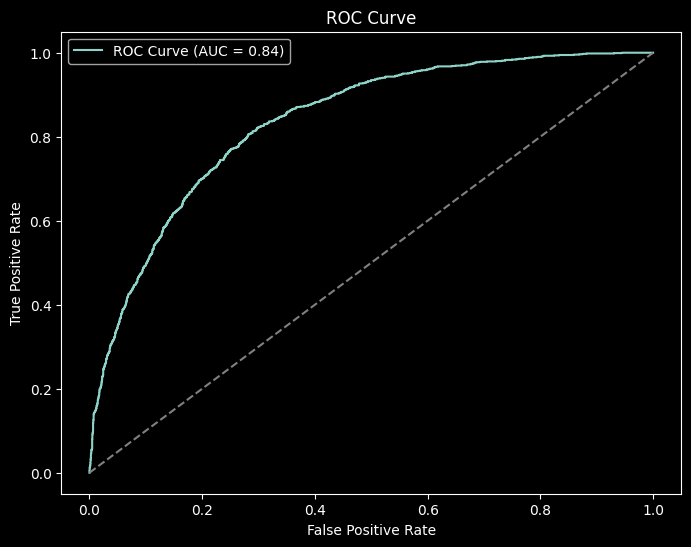

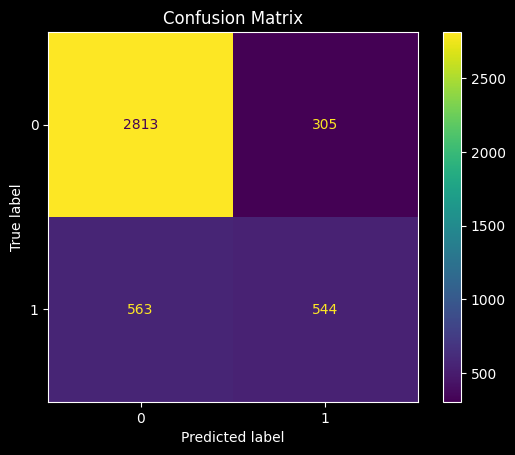

In [ ]:
# Получим предсказание для той же выборки, для визуализации матрицы ошибок
y_pred = log_model.predict(X_train)
# Построим ROC-кривую для этой модели
y_pred_proba = log_model.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Построим график ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Визуализация матрицы ошибок
cm = confusion_matrix(y_train, y_pred, labels=log_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=log_model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

### Вывод. Линейная модель.

+ Значение ROC-AUC равное 0.835 указывает на хорошую способность модели разделять классы, но недостаточную.

+ Исходя из матрицы ошибок выше, можем проанализировать производительность нашей модели:

    + 544 истинно положительных (True Positives) случаев. Это количество клиентов, которых модель правильно предсказала как ушедших (churn = 1).

    + 305 ложноположительных (False Positives) случаев. Это количество клиентов, которых модель неправильно предсказала как ушедших (churn = 1), когда они фактически остались (churn = 0).

    + 2813 истинноотрицательных (True Negatives) случаев. Это количество клиентов, которых модель правильно предсказала как оставшихся (churn = 0).

    + 563 ложноотрицательных (False Negatives) случаев. Это количество клиентов, которых модель неправильно предсказала как оставшихся (churn = 0), когда они фактически ушли (churn = 1).

Большое количество ложноотрицательных случаев(False Negatives) говорит о том, что модель недостаточно чувствительна к выявлению положительных случаев (например, клиентов, которые действительно ушли).

Для дальнейших итераций необходимо будет учесть, что влияет на это баланс классов, поможет решить эту проблему для линейных моделей те приемы, которые были описаны ранее, но так как мы хотим сохранить больше информации о данных, мы перейдем к следующей модели, более сложной - Случайному лесу, получив бейзлайн метрику равной AUC - 0.835

## RandomForestClassifier

Теперь перейдем к модели Случайного леса

In [ ]:
# Создаем пайплайны для численных и категориальных признаков
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

# Объединяем пайплайны
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Создаем пайплайны для модели случайного леса
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier())
])

In [ ]:
# Задаем сетку для перебора параметров
param_grid = {
    'clf__n_estimators': [200, 300],  # Количество деревьев в лесу
    'clf__max_depth': [6, 8, 10],  # Максимальная глубина деревьев
    'clf__min_samples_split': [7, 9],  # Минимальное количество объектов для разделения узла
    'clf__min_samples_leaf': [10, 12, 14],  # Минимальное количество объектов в листе
    'clf__max_features': ['log2', 'sqrt'],  # Количество признаков для разбиения
    'clf__bootstrap': [True],  # Использование Bootstrap выборки
    'clf__class_weight': ['balanced'], # Балансировка классов
    'clf__random_state': [RANDOM_STATE],
}

In [ ]:
# Инициализируем GridSearchCV
rand_search = GridSearchCV(
    rf_pipeline, param_grid,
    refit=True, n_jobs=-1,
    cv=5, scoring='roc_auc',
)
# Обучаем модель и выводим структуру нашей системы
rand_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['client_period', 'monthly_spending', 'total_spent'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         Index(['sex', 'is_senior_citizen', 'has_partner', 'has_child',
       'has_phone_service'...
       'is_billing_paperless', 'payment_method'],
      dtype='object'))])),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'clf__bootstrap': [True],
                         'clf__class_weight': ['balanced'],
                         'clf__max_depth': [6, 8, 10],
                         'clf__max_features': ['log2', 'sqrt'],
                         'clf__min_samples_leaf': [10, 12, 14],
                         'clf__min_samples_split': [7, 9],
                         'clf__n_estimators': [200, 300],
                         'clf__random_state': [42]},
             scoring='roc_auc')

In [ ]:
# Сохраняем лучшие параметры
rf_params = rand_search.best_params_
# Лучший скор
rf_score = rand_search.best_score_
# Лучшую модель
rf_model = rand_search.best_estimator_

print("Лучшие параметры случайного леса:\n", rf_params)
print("\nЛучший ROC_AUC для случайного леса:", rf_score)

Лучшие параметры случайного леса:
 {'clf__bootstrap': True, 'clf__class_weight': 'balanced', 'clf__max_depth': 8, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 7, 'clf__n_estimators': 200, 'clf__random_state': 42}

Лучший ROC_AUC для случайного леса: 0.8431392108132792


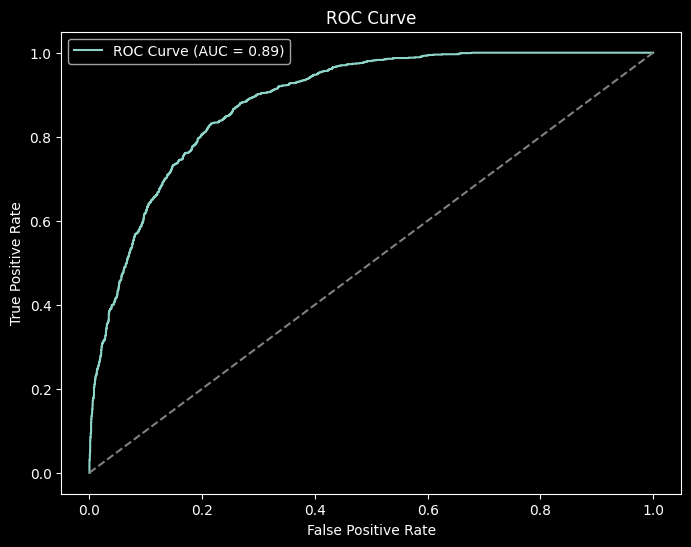

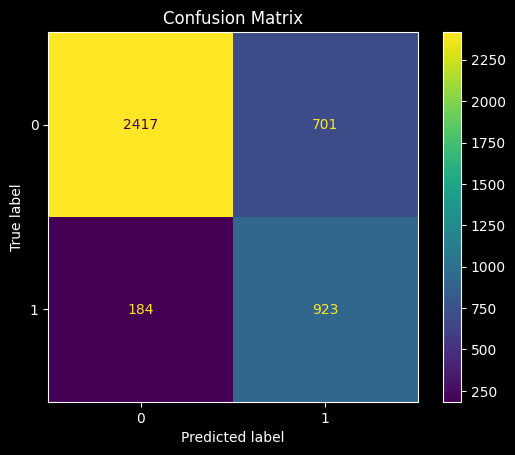

In [ ]:
# Получим предсказание для той же выборки, для визуализации матрицы ошибок
y_pred = rf_model.predict(X_train)

# Построим ROC-кривую для этой модели
y_pred_proba = rf_model.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Построим график ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Визуализация матрицы ошибок
cm = confusion_matrix(y_train, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=rf_model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

## Вывод по модели случайного леса:

Обучение происходило дольше, и гиперпараметров перебрали намного больше, чем в бейзлайн решении
Мы немного превзошли метрику бейзлайна на кросс-валидации, но roc_auc получился больше во время замера на тестовой выборке, это может говорить о том, что:
+ Во время кросс-валидации модель обучается на различных подмножествах данных, и каждая итерация может использовать разные фолды. Это может привести к небольшим изменениям в производительности модели, так как данные для обучения и валидации меняются на каждой итерации.
+ Случайный лес, использует рандомизациюц во время обучения. Это может привести к некоторым различиям в результатах на разных подвыборках.

Матрица ошибок для модели случайного леса выглядит следующим образом:

True Negative (TN): 2417 - это количество отрицательных примеров, которые модель правильно классифицировала как отрицательные. Это случаи, когда модель правильно предсказала, что клиенты не ушли.

True Positive (TP): 923 - это количество положительных примеров, которые модель правильно классифицировала как положительные. В данном случае это, клиенты, которые действительно ушли.

False Negative (FN): 184 - это количество положительных примеров, которые модель неправильно классифицировала как отрицательные. Это ошибки модели, когда она не смогла предсказать уход клиентов.

False Positive (FP): 701 - это количество отрицательных примеров, которые модель неправильно классифицировала как положительные. Это ошибки модели, когда она неверно предсказала, что клиенты ушли.


+ Модель правильно классифицирует большинство клиентов как оставшихся (2417 TN) и также правильно классифицирует множество клиентов как ушедших (923 TP).
+ Однако она допускает ошибки, классифицируя некоторых оставшихся клиентов как ушедших (701 FP) и некоторых ушедших клиентов как оставшихся (184 FN).

Исходя матрицы ошибок, модель случайного леса имеет некоторый потенциал для улучшения в смысле снижения ложноположительных и ложноотрицательных предсказаний, чтобы улучшить качество классификации клиентов.


Важно помнить, что результаты на обучающей выборке могут быть переобучены, поэтому оценка производительности на отложенной тестовой выборке или на новых данных также является важным шагом для проверки и обобщения работы модели. Поэтому перейдем к следующей модели - градиентному бустингу

## Применение градиентного бустинга

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки.   
Catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

In [ ]:
catboost_model = CatBoostClassifier(cat_features=categorical_features.values, verbose=False)

param_grid = {
    'iterations': [1000, 2000],  # Количество итераций (деревьев)
    'learning_rate': [0.01, 0.001],  # Скорость обучения
#     'depth': [4, 6],  # Глубина деревьев
    'verbose': [False],
#     'l2_leaf_reg': [1, 0.1, 0.5],
    'auto_class_weights': ['Balanced'],
    'random_seed': [RANDOM_STATE]
}

In [ ]:
# Инициализируем GridSearchCV
cat_search = GridSearchCV(catboost_model, param_grid, cv=5, scoring='roc_auc')
# Обучаем модель и выводим структуру нашей системы
cat_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7de374aa52a0>,
             param_grid={'auto_class_weights': ['Balanced'],
                         'iterations': [1000, 2000],
                         'learning_rate': [0.01, 0.001], 'random_seed': [42],
                         'verbose': [False]},
             scoring='roc_auc')

In [ ]:
# Сохраняем лучшие параметры
cat_params = cat_search.best_params_
# Лучший скор
cat_score = cat_search.best_score_
# Лучшую модель
cat_model = cat_search.best_estimator_

print("Лучшие параметры градиентного бустинга:\n", cat_params)
print("\nЛучший ROC_AUC градиентного бустинга:", cat_score)

Лучшие параметры градиентного бустинга:
 {'auto_class_weights': 'Balanced', 'iterations': 1000, 'learning_rate': 0.01, 'random_seed': 42, 'verbose': False}

Лучший ROC_AUC градиентного бустинга: 0.8451591452198371


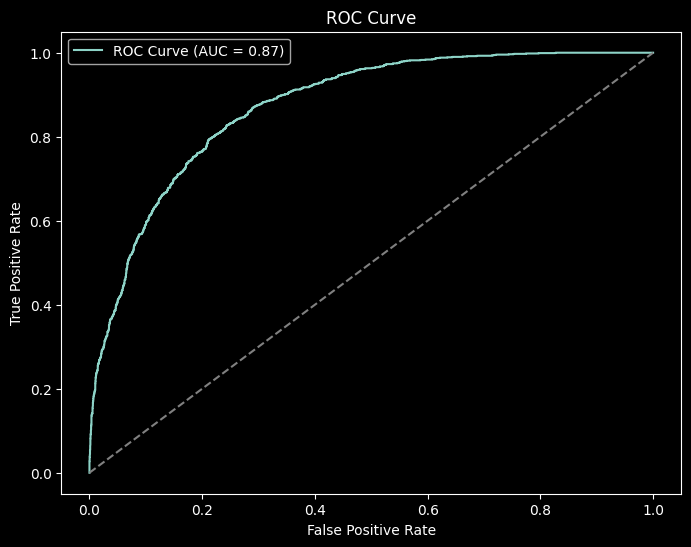

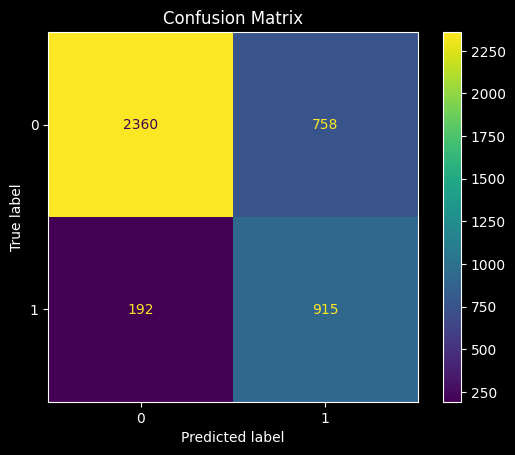

In [ ]:
# Получим предсказание для той же выборки, для визуализации матрицы ошибок
y_pred = cat_model.predict(X_train)

# Построим ROC-кривую для этой модели
y_pred_proba = cat_model.predict_proba(X_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Построим график ROC-кривой
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Визуализация матрицы ошибок
cm = confusion_matrix(y_train, y_pred, labels=cat_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=cat_model.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

ROC_AUC градиентного бустинга: 0.844 означает, что наша модель градиентного бустинга демонстрирует хорошее качество в разделении классов.  
С меньшими вмешательствами в данные, по скорости обучения на кросс-валидации примерно равна обучению предыдущих моделей  
Мы подобрали гиперпараметры и готовы выбрать эту модель в качестве лучшей, для тестирования на финальной отложенной выборке  

Для полностью сохраненных данных это отличный показатель  
Для следующих итераций можно использовать RandomizedSearchCV для быстрого подбора границ, в котором уже можно подробнее подбирать параметры с помощью GSCV

+ График ROC-кривой:
    + ROC_AUC градиентного бустинга: 0.844 означает, что наша модель градиентного бустинга демонстрирует хорошее качество в разделении классов.

+ Матрица ошибок:
    + 2378 - True Negatives (TN): Количество правильно предсказанных отрицательных случаев.
    + 740 - False Positives (FP): Количество ложноположительных случаев (ошибки первого рода).
    + 197 - False Negatives (FN): Количество ложноотрицательных случаев (ошибки второго рода).
    + 910 - True Positives (TP): Количество правильно предсказанных положительных случаев.

Посмотрим на важность признаков для CatBoost

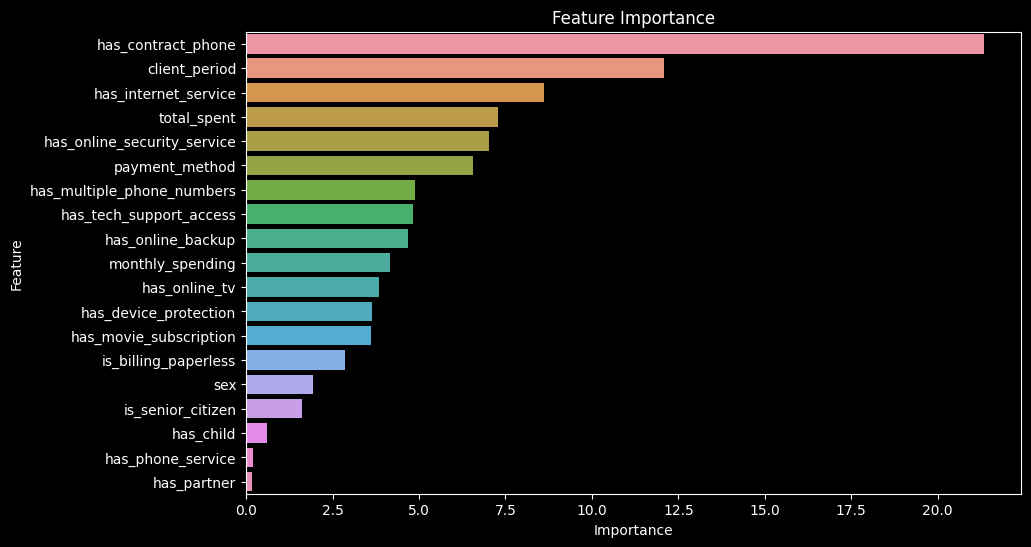

In [ ]:
# Получение важности признаков из модели CatBoost
feature_importances = cat_model.get_feature_importance()

# Создание DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

Важности признаков:

+ has_contract_phone имеет самую высокую важность, с величиной важности около 24.21.
+ client_period также обладает значительной важностью, с величиной приблизительно 12.31.
+ На третьем месте has_internet_service с значением 8.02

В целом есть заметная разница между фи-ком и тем, как модель нашла зависимости, как в важных признаках, так и в менее важных

## Вывод. Исследование моделей.

In [ ]:
result = pd.DataFrame({
    'LogisitRegression': log_score,
    'RandomForest': rf_score,
    'CatBoost': cat_score,
}, index=['score'])
result.T.style.background_gradient(cmap=cmap)

,score
LogisitRegression,0.834776
RandomForest,0.843139
CatBoost,0.845159


Мы провели большое исследование и изучили 3 модели:
+ LogisticRegression:  
    Для этой линейной модели мы использовали преобразование числовых (StandardScaler) и категориальных признаков (OHE)  
    После мы преобразовали признаки методом главных компонент, для устранения очень высокой корреляции между признаками
    Провели подбор гиперпараметров на кросс-валидации и замерили качество по метрике ROC_AUC
    Модель оказалась самой быстрой из всех исследованных, но качество меньше, чем у последующих
+ RandomForestClassifier:  
    Признаки для этой модели мы преобразовали таким же способом как и у предыдущей модели
    Модель значительно дольше обучалась на кросс-валидации, перебрали больше гиперпараметров и получили метрику выше, чем у бейзлайн-модели
+ CatBoostClassifier:
    Для данной модели мы не масштабировали признаки, она хорошо справляется с этим сама, от нас было необходимо только указать категориальные признаки, для их дальнейшей обработки в самой модели, что мы и сделали
    По времени эта модель была сравнима с случайным лесом и получила самый высокий скор среди тестируемых моделей, именно ее мы и выбрали для финального тестирования на отложенной выборке
    
    Переходим к тестированию!

## Тестирование финальной модели

Протестируем финальную модель на отложенной выборке и получим финальную метрику!

In [ ]:
# Предсказываем вероятности
final_pred = cat_model.predict_proba(X_test)[:, -1]
# Выводим финальный скор
final_result = roc_auc_score(y_test, final_pred)

print('Финальный ROC_AUC модели CatBoost: ', final_result)

Финальный ROC_AUC модели CatBoost:  0.8562181801351477


## Предсказания


In [ ]:

best_model = cat_model # какая-то предыдущая модель

submission['Churn'] =  best_model.predict_proba(test)[:, -1]
# submission.to_csv('./my_submission.csv')

# Лучшее решение отправьте в Stepik.

## Финальный вывод


Мы проделали огромную работу, а именно:

+ Загрузили и изучили данные, нашли проблемные места:

    + Размер тренировочной выборки 5282 объекта на 20 признаков
    + В тренировочной выборке 3 признака непрерывных и 17 категориальных (8 из которых бинарные) один из них наш целевой признак,
    + Признаки имели формат PascalCase, перевели в привычный парселтанг (snake_case),
    + Признак total_spent имел некорректный тип данных object - перевели в float, также имелись пустые значения в количестве 9 штук (пустая строка), заменили на NaN провели анализ гипотезы и приняли решение заполнить пропущенные значения значениями из признака monthly_spending
    + Тип признака is_senior_citizen числовой, уже преобразованный, оставим его для кодировщиков
    + Дубликаты в данной задаче не имеют значения, так как возможны полные копии наблюдений, но могут относится к разным пользователям, в данном случае присутствуют полные дубликаты наблюдений с временем пользования сервисами равным одному месяцу
    + Пропусков нет


+ Провели исследовательский анализ данных, а также определили среднего пользователя компании:

    + Категориальные признаки:
        + Целевой признак несбалансирован, соотношение 76 к 24%, необходимо это учесть при исследовании моделей
        + Способ оплаты доминирует electronic_check, остальные способы примерно равны между собой
        + Большая часть пользователей предпочитает не получать бумажные чеки
        + У большинства пользователей подключена помесячная подписка на телефон, в два раза меньше пользователей пользуются двухгодичной подпиской, немного меньше ежегодной
        + Примерно одинаковое количество людей кто пользуется подпиской на фильмы и тех у кого нет подписки, в половину меньше у кого нет интернет сервиса
        + У большего числа пользователей нет онлайн тв, чуть меньше пользователей имеют телевидение, в два раза меньше пользователей у которых нет интернет сервиса
        + Большее число пользователей не имеют сервиса технической поддержки
        + Также дела обстоят с сервисом защиты устройств, онлайн резеврной копией, онлайн службой безопасности
        + Большинство пользователей использую оптоволоконное подключение, чуть меньше пользователей используют цифровое подключение
        + Возможностю подключения телефонного номера к нескольким линиям одновременно не пользуется большинство пользователей, чуть меньше подключили такую услугу, достаточно мало человек не используют телефонные сервисы
        + Распределение в выборке мужчин и женщин примерно одинаково, такая же ситуация с наличием партнера, большинство не имеет детей и не пенсионного возраста
    
    
    + Численные признаки:
        + client_period:

            Гистограмма для client_period показывает, что большинство клиентов пользовались услугами компании относительно недавно, с низким значением client_period.  
            Это видно из высокого столбца близкого к 0 на гистограмме.   
            Со временем количество клиентов убывает, что видно из уменьшения высоты столбцов при увеличении client_period.
            Однако есть также большая доля клиентов, которые пользуются услугами длительное время и составляют второй пик в конце.
            Распределение признака напоминает экспоненциальное распределение с двумя пиками.

        + monthly_spending:

            Гистограмма для monthly_spending показывает, что есть пик при низких ежемесячных трат и более равномерное низкое распределение далее, меньше всего пользователей с ежемесечной платой в диапазоне от 30 до 45.   
            Это указывает на наличие основной группы клиентов: с низкими ежемесячными расходами.   
            Распределение признака является одномодальным, с одним характерным значением.  

        + total_spent:

            Распределение признака total_spent является также одномодальным, с одним характерным значением, и показывает, что большинство клиентов имеют низкие общие траты.
            Присутствует жирный хвост до значений больше 8_000  
            Значения плавно уходят в жирный хвост, с увеличением общих трат и уменьшается количество пользователей.  
            Распределение признака является одномодальным.
            
+ Перед исследованием моделей изучили важность признаков с помощью фи-ка:
        
    + Матрица корреляции:

        + Сильная корреляция между некоторыми признаками:   
            Все признаки интернет сервисов очень сильно положительно коррелируют друг с другом, что приведет к мультиколлинеарности  
            Это усложняет интерпретацию важности каждого из этих признаков и может привести к нестабильным оценкам модели. Например, has_online_security_service, has_online_backup, has_device_protection, и has_tech_support_access сильно коррелируют друг с другом. Рассмотрим удаление некоторых из них.

        + Слабая корреляция с целевой переменной:  
            Некоторые признаки имеют низкую корреляцию с целевой переменной churn. Например, has_multiple_phone_numbers, sex, has_phone_service имеют практически нулевую корреляцию с churn.   
            Эти признаки не предоставляют значимой информации для прогнозирования ухода клиентов и могут быть исключены.

        + Смещение в данных:
            Имеется неравномерное распределение значений в некоторых признаках, что может вызвать проблемы при обучении модели. Например, если у большинства клиентов значение признака близко к нулю, это может привести к смещению модели.  
            Будем нормировать численные признаки

        + Сильные стороны:

            Корреляция с целевой переменной: Некоторые признаки, такие как client_period, payment_method, monthly_spending, имеют среднюю корреляцию с целевой переменной churn. Эти признаки могут быть полезны для прогнозирования ухода клиентов.  


На первой итерации мы старались максимально сохранить всю информацию о данных
    
+ Мы провели большое исследование и изучили 3 модели:
    + LogisticRegression:  
        Для этой линейной модели мы использовали преобразование числовых (StandardScaler) и категориальных признаков (OHE)  
        После мы преобразовали признаки методом главных компонент, для устранения очень высокой корреляции между признаками
        Провели подбор гиперпараметров на кросс-валидации и замерили качество по метрике ROC_AUC
        Модель оказалась самой быстрой из всех исследованных, но качество меньше, чем у последующих
    + RandomForestClassifier:  
        Признаки для этой модели мы преобразовали таким же способом как и у предыдущей модели
        Модель значительно дольше обучалась на кросс-валидации, перебрали больше гиперпараметров и получили метрику выше, чем у бейзлайн-модели
    + CatBoostClassifier:
        Для данной модели мы не масштабировали признаки, она хорошо справляется с этим сама, от нас было необходимо только указать категориальные признаки, для их дальнейшей обработки в самой модели, что мы и сделали
        По времени эта модель была сравнима с случайным лесом и получила самый высокий скор среди тестируемых моделей, именно ее мы и выбрали для финального тестирования на отложенной выборке
        
        
## Итог

Мы можем сказать, что с достаточной точность можем предсказывать уход пользователей и с задачей справились

## UPD

На следующей итерации необходимо будет добавить функцию, для вывода графиков conf_matrix и roc_curve, иначе не комильфо

![Вот так](https://a.d-cd.net/l8AAAgCtK-A-1920.jpg)